<a href="https://colab.research.google.com/github/mehang/3D-DNA/blob/master/notebook/Cats%5C%20Vs%5C%20Dogs/Resized%5C%20cats%5C%20vs%5C%20dogs/Collab_Pandas_Gabor_Cats_vs_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import pathlib

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


In [3]:
!unzip /content/drive/My\ Drive/Gabor\ Dataset/all-cats-vs-dogs.zip -d cats-vs-dogs

Streaming output truncated to the last 5000 lines.
  inflating: cats-vs-dogs/all/cat.8674.jpg  
  inflating: cats-vs-dogs/all/cat.4471.jpg  
  inflating: cats-vs-dogs/all/cat.4193.jpg  
  inflating: cats-vs-dogs/all/cat.8593.jpg  
  inflating: cats-vs-dogs/all/cat.8512.jpg  
  inflating: cats-vs-dogs/all/cat.6828.jpg  
  inflating: cats-vs-dogs/all/cat.1070.jpg  
  inflating: cats-vs-dogs/all/cat.4311.jpg  
  inflating: cats-vs-dogs/all/cat.983.jpg  
  inflating: cats-vs-dogs/all/cat.448.jpg  
  inflating: cats-vs-dogs/all/cat.2922.jpg  
  inflating: cats-vs-dogs/all/cat.10328.jpg  
  inflating: cats-vs-dogs/all/cat.3356.jpg  
  inflating: cats-vs-dogs/all/cat.11657.jpg  
  inflating: cats-vs-dogs/all/cat.3913.jpg  
  inflating: cats-vs-dogs/all/cat.4196.jpg  
  inflating: cats-vs-dogs/all/cat.11509.jpg  
  inflating: cats-vs-dogs/all/cat.4105.jpg  
  inflating: cats-vs-dogs/all/cat.6044.jpg  
  inflating: cats-vs-dogs/all/cat.6846.jpg  
  inflating: cats-vs-dogs/all/cat.10357.jpg  
  

In [4]:
FAST_RUN = False
IMAGE_WIDTH=256
IMAGE_HEIGHT=256
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [5]:
filenames = os.listdir("cats-vs-dogs/all/")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [6]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [7]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [8]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=32


In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
)
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "cats-vs-dogs/all/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [10]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "cats-vs-dogs/all/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [11]:
# Importing the Keras libraries and packages
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

num_classes = 2

classifier = Sequential([
    # layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_size, img_size, 3)),
    layers.Conv2D(32, kernel_size=(15,15), strides=(1,1), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    layers.Conv2D(64, kernel_size=(3,3), strides=(2,2), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(128, kernel_size=(3,3), strides=(2,2), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    Dropout(0.5),
    layers.Dense(num_classes)
])

classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 242, 242, 32)      21632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 121, 121, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 121, 121, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 128)         0

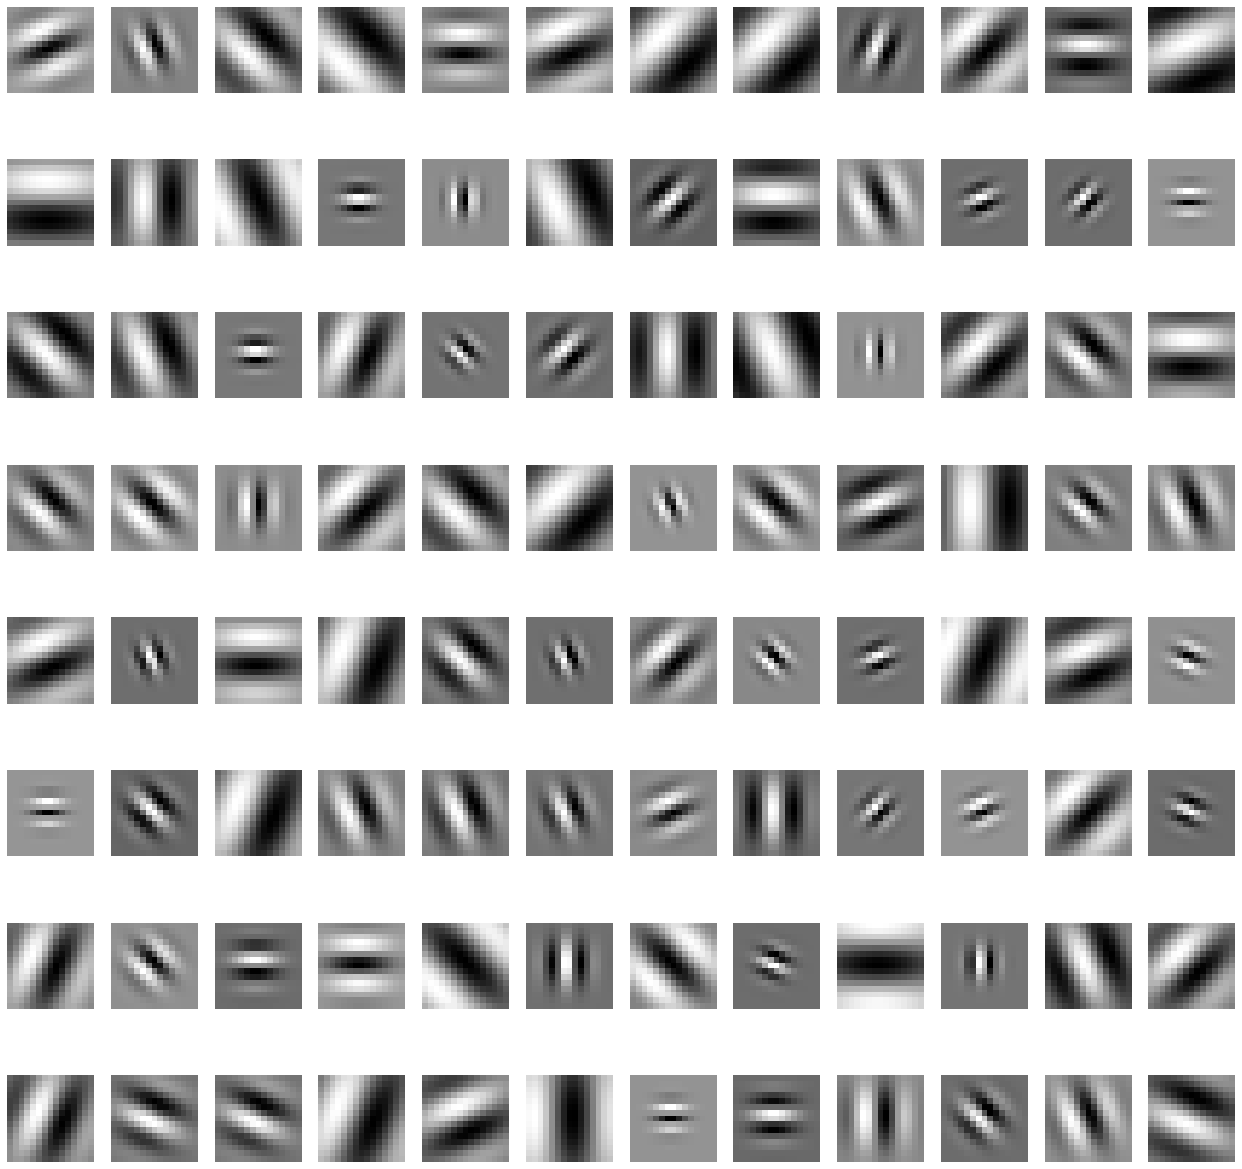

In [12]:
import math

def get_gabor_filters(inchannels, outchannels, kernel_size = (3,3)):
    delta = 1e-4
    freqs = (math.pi/2)*(math.sqrt(2)**(-np.random.randint(0,5, (outchannels, inchannels))))
    thetas = (math.pi/8)*np.random.randint(0,8, (outchannels, inchannels))
    sigmas = math.pi/(freqs)
    psis = math.pi * np.random.rand(outchannels, inchannels)
    x0, y0 = np.ceil(np.array(kernel_size)/2)    
    
    y, x = np.meshgrid(
            np.linspace(-x0 + 1, x0 + 0, kernel_size[0]),
            np.linspace(-y0 + 1, y0 + 0, kernel_size[1]),
    )
    filterbank = []
    
    for i in range(outchannels):
        for j in range(inchannels):
            freq = freqs[i][j]
            theta = thetas[i][j]
            sigma = sigmas[i][j]
            psi = psis[i][j]
            
            rotx = x * np.cos(theta) + y * np.sin(theta)
            roty = -x * np.sin(theta) + y * np.cos(theta)

            g = np.exp(
                -0.5 * ((rotx ** 2 + roty ** 2) / (sigma + delta) ** 2)
            )
            g = g * np.cos(freq * rotx + psi)
#             g = g / (2 * math.pi * (sigma ** 2))
#             g = gabor_kernel(frequency=freq, bandwidth=sigma, theta=theta, offset=psi, n_stds=0).real
            filterbank.append(g)
    return filterbank

filterbank = get_gabor_filters(3, 32, (15,15))

fig = plt.subplots(8, len(filterbank)//8, figsize=(22,22))
for i,gf in enumerate(filterbank):
    plt.subplot(8, len(filterbank)//8, i+1)
    plt.imshow(gf, cmap='gray')
    plt.axis('off')

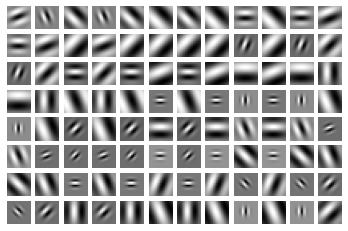

In [13]:
cnnl1 = classifier.layers[0].name   # get the name of the first conv layer
W = classifier.get_layer(name=cnnl1).get_weights()[0]   #get the filters
wshape = W.shape  #save the original shape
gabor_filters = W
for kernel_index in range(wshape[3]):
    for channel_index in range(3):
        gabor_filters[:,:,channel_index, kernel_index] = filterbank[kernel_index+channel_index]

classifier.get_layer(name=cnnl1).set_weights([gabor_filters, classifier.get_layer(name=cnnl1).get_weights()[1]])
filter_layers = []
for i in range(32):
    for j in range(3):
        filter_layers.append(np.reshape(W[:,:,j, i], (15,15)))
for i,gf in enumerate(filter_layers):
    plt.subplot(8, len(filterbank)//8, i+1)
    plt.imshow(gf, cmap='gray')
    plt.axis('off')

In [14]:
wshape

(15, 15, 3, 32)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import time

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,  
                              min_delta=1e-4, mode='min', verbose=1)

stop_alg = EarlyStopping(monitor='val_loss', patience=35, 
                         restore_best_weights=True, verbose=1)

callbacks = [stop_alg, reduce_lr]

epochs=20 if FAST_RUN else 1000

start = time.perf_counter()
classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = classifier.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)
finish = time.perf_counter()

Epoch 1/1000
625/625 [==============================] - 72s 115ms/step - loss: 0.7113 - accuracy: 0.5103 - val_loss: 0.6902 - val_accuracy: 0.5214
Epoch 2/1000
625/625 [==============================] - 71s 113ms/step - loss: 0.6756 - accuracy: 0.5816 - val_loss: 0.6232 - val_accuracy: 0.6516
Epoch 3/1000
625/625 [==============================] - 71s 113ms/step - loss: 0.6475 - accuracy: 0.6358 - val_loss: 0.6661 - val_accuracy: 0.5797
Epoch 4/1000
625/625 [==============================] - 71s 113ms/step - loss: 0.6532 - accuracy: 0.6148 - val_loss: 0.6047 - val_accuracy: 0.6775
Epoch 5/1000
625/625 [==============================] - 70s 112ms/step - loss: 0.5809 - accuracy: 0.7042 - val_loss: 0.5257 - val_accuracy: 0.7492
Epoch 6/1000
625/625 [==============================] - 70s 111ms/step - loss: 0.6461 - accuracy: 0.6236 - val_loss: 0.5798 - val_accuracy: 0.6991
Epoch 7/1000
625/625 [==============================] - 69s 111ms/step - loss: 0.5748 - accuracy: 0.7023 - val_loss: 0

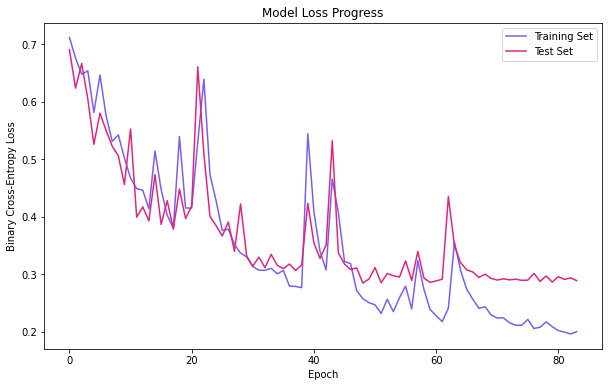

In [16]:
import matplotlib.pyplot as plt

hist=history

fig = plt.figure(figsize=(10,6))
plt.plot(hist.history['loss'], color='#785ef0')
plt.plot(hist.history['val_loss'], color='#dc267f')
plt.title('Model Loss Progress')
plt.ylabel('Binary Cross-Entropy Loss')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper right')
plt.savefig('cnn-gabor.loss-2.png', dpi=350, bbox_inches='tight')
plt.show()

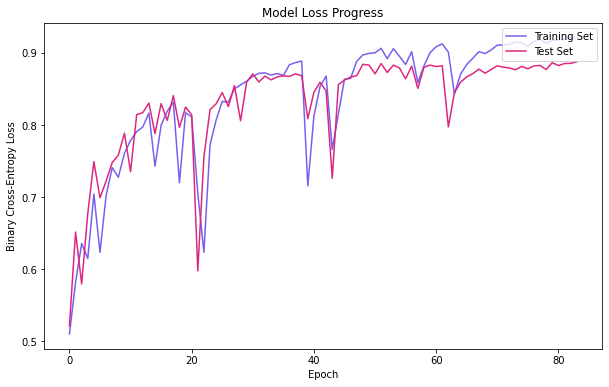

In [17]:
fig = plt.figure(figsize=(10,6))
plt.plot(hist.history['accuracy'], color='#785ef0')
plt.plot(hist.history['val_accuracy'], color='#dc267f')
plt.title('Model Loss Progress')
plt.ylabel('Binary Cross-Entropy Loss')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper right')
plt.savefig('cnn-gabor-accuracy-2.png', dpi=350, bbox_inches='tight')
plt.show()

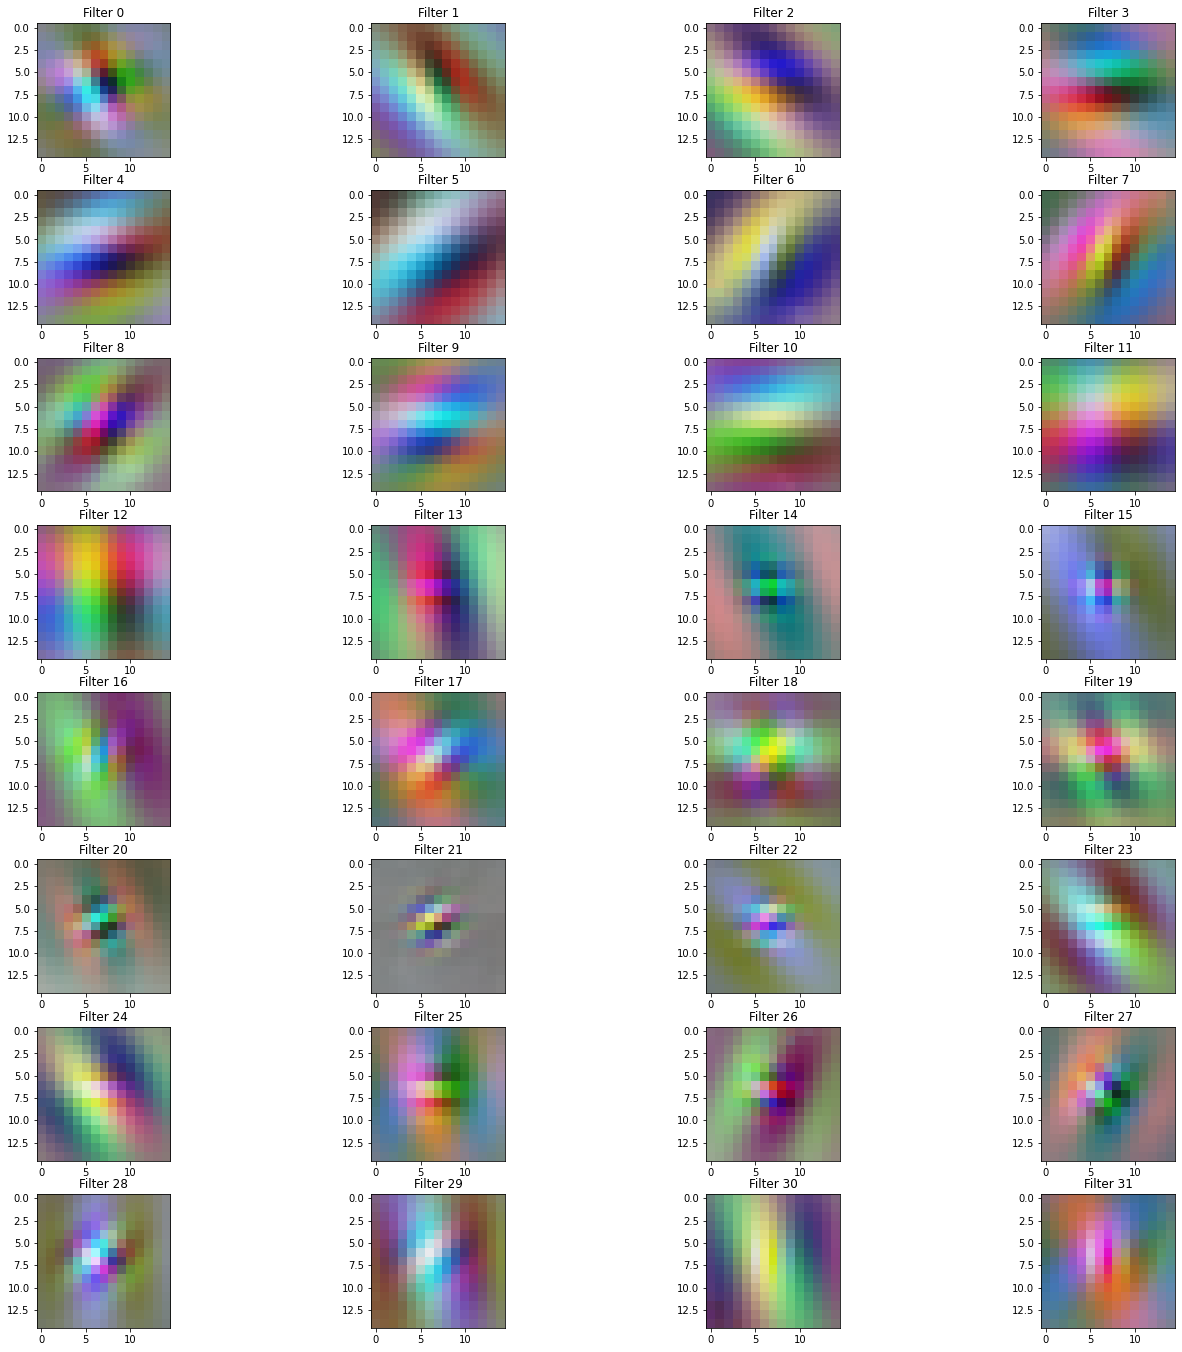

In [18]:
from sklearn.preprocessing import MinMaxScaler

cnnl1 = classifier.layers[0].name   # get the name of the first conv layer
W = classifier.get_layer(name=cnnl1).get_weights()[0]   #get the filters
wshape = W.shape  #save the original shape

# this part will scale to [0, 1] for visualization purposes
scaler = MinMaxScaler()
scaler.fit(W.reshape(-1,1))
W = scaler.transform(W.reshape(-1,1))
W = W.reshape(wshape)

# since there are 64 filters, we will display them 8x8
fig, axs = plt.subplots(8,4, figsize=(24,24))
fig.subplots_adjust(hspace = .25, wspace=.001)
axs = axs.ravel()
for i in range(W.shape[-1]):
  # we reshape to a 3D (RGB) image shape and display
  h = np.reshape(W[:,:,:,i], (15,15,3))
  axs[i].imshow(h)
  axs[i].set_title('Filter ' + str(i))    
plt.savefig("cnn-gabor.full.filters-2.png", bbox_inches='tight', dpi=350)

-1.2026954 1.2085522


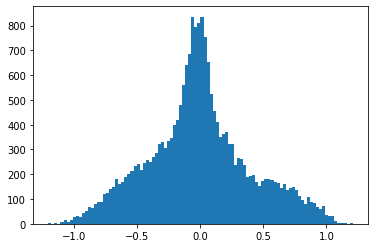

In [19]:
cnnl1 = classifier.layers[0].name   # get the name of the first conv layer
W = classifier.get_layer(name=cnnl1).get_weights()[0]
plt.hist(W.ravel(), bins=100)
print(np.min(W),np.max(W))

In [20]:
finish-start

5738.814935322001